In [444]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phuongtran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [324]:
#Read the data
df = pd.read_csv("Release 2 - Food Details.csv")
df.head(1)

,Public Food Key,Food Profile ID,Derivation,Food Name,Food Description,Sampling Details,Nitrogen Factor,Fat Factor,Specific Gravity,Analysed Portion,Unanalysed Portion,Classification,Classification Name
0,F002258,14723,Borrowed,"Cardamom seed, dried, ground","Ground spice commonly used in Indian cooking and drinks, in Middle Eastern cooking and in Scandinavian baking","The majority of nutrient data were borrowed from USDA SR28, 02006 - Spices, cardamom. Proximates (starch, total sugars), vitamins (alpha-tocopherol, beta-carotene, folate) and Se were borrowed from Indian Food Composition Tables 2017, G020 - Cardamom, green. Dry matter adjustment was applied to starch and sugar. Tryptophan was imputed from dried fenugreek seed. Alcohol, vitamins (B12, folic acid, retinol, D), I, caffeine and cholesterol were imputed zero. Note low sum of proximates - data should be used with caution.",6.25,0.96,0,100%,0%,31302.0,Herbs(dried) and spices


In [402]:
len(df)

1617

In [325]:
#Choose only column Food
df_food = df['Food Name'].reset_index()
df_food.columns = ['Index','Food']
df_food

,Index,Food
0,0,"Cardamom seed, dried, ground"
1,1,"Cinnamon, dried, ground"
2,2,"Cloves, dried, ground"
3,3,"Coriander seed, dried, ground"
4,4,"Cumin (cummin) seed, dried, ground"
...,...,...
1612,1612,"Yoghurt, coconut based, flavoured"
1613,1613,"Yoghurt, flavoured, high fat (approx 5%)"
1614,1614,"Yoghurt, flavoured, low fat (0.2%), intense sweetened, increased protein"
1615,1615,"Yoghurt, flavoured, low fat (approx 2%)"


### Remove punctuations, numbers, stop words from Food column

In [326]:
df_food["Food 2"] = df_food['Food'].str.replace(r'[^\w\s]+', '')
df_food["Food 2"] = df_food['Food 2'].str.replace('\d+', '')

stop = stopwords.words('english')
df_food["Food 2"] = df_food["Food 2"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_food.head()

<ipython-input-326-210ddfa41823>:2: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-326-210ddfa41823>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



,Index,Food,Food 2
0,0,"Cardamom seed, dried, ground",Cardamom seed dried ground
1,1,"Cinnamon, dried, ground",Cinnamon dried ground
2,2,"Cloves, dried, ground",Cloves dried ground
3,3,"Coriander seed, dried, ground",Coriander seed dried ground
4,4,"Cumin (cummin) seed, dried, ground",Cumin cummin seed dried ground


### Word stemming 

In [333]:
#Reduce a word to its word stem.
def stem_sentences(sentence):
    porter_stemmer = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter_stemmer.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

df_food['Food 2'] = df_food['Food 2'].apply(stem_sentences)
df_food['Food 2'] = df_food['Food 2'].str.lower()
df_food.head(10)

,Index,Food,Food 2
0,0,"Cardamom seed, dried, ground",cardamom seed dri ground
1,1,"Cinnamon, dried, ground",cinnamon dri ground
2,2,"Cloves, dried, ground",clove dri ground
3,3,"Coriander seed, dried, ground",coriand seed dri ground
4,4,"Cumin (cummin) seed, dried, ground",cumin cummin seed dri ground
5,5,Curry powder,curri powder
6,6,"Fenugreek seed, dried",fenugreek seed dri
7,7,"Ginger, dried, ground",ginger dri ground
8,8,Mustard powder,mustard powder
9,9,"Nutmeg, dried, ground",nutmeg dri ground


### Bag of Words

In [332]:
#Count the occurences of each word in Food column.
vectorizer_cv = CountVectorizer(analyzer='word')
vec = vectorizer_cv.fit_transform(df_food['Food 2'])

matrix = pd.concat([df_food['Food'], pd.DataFrame(vec.toarray(), columns = vectorizer_cv.get_feature_names())], axis = 1)
matrix[['Food', 'cinnamon','dri', 'ground']].head(10)

,Food,cinnamon,dri,ground
0,"Cardamom seed, dried, ground",0,1,1
1,"Cinnamon, dried, ground",1,1,1
2,"Cloves, dried, ground",0,1,1
3,"Coriander seed, dried, ground",0,1,1
4,"Cumin (cummin) seed, dried, ground",0,1,1
5,Curry powder,0,0,0
6,"Fenugreek seed, dried",0,1,0
7,"Ginger, dried, ground",0,1,1
8,Mustard powder,0,0,0
9,"Nutmeg, dried, ground",0,1,1


### TF-IDF Matrix

In [408]:
#Evaluate how important a word is to a document in a collection or corpus.
vectorizer_tfidf = TfidfVectorizer(analyzer='word')
tfidf_matrix = vectorizer_tfidf.fit_transform(df_food['Food 2'])

matrix2 = pd.concat([df_food['Food'], pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer_tfidf.get_feature_names())], axis = 1)
matrix2[['Food', 'cinnamon','dri', 'ground']].head(10)

,Food,cinnamon,dri,ground
0,"Cardamom seed, dried, ground",0.00000,0.328683,0.486580
1,"Cinnamon, dried, ground",0.73239,0.381129,0.564221
2,"Cloves, dried, ground",0.00000,0.369954,0.547678
3,"Coriander seed, dried, ground",0.00000,0.336445,0.498071
4,"Cumin (cummin) seed, dried, ground",0.00000,0.273472,0.404846
5,Curry powder,0.00000,0.000000,0.000000
6,"Fenugreek seed, dried",0.00000,0.376224,0.000000
7,"Ginger, dried, ground",0.00000,0.389292,0.576306
8,Mustard powder,0.00000,0.000000,0.000000
9,"Nutmeg, dried, ground",0.00000,0.369954,0.547678


## K-Means Clustering

In [282]:
#Find the best k (using elbow method): For each k value, we will use the inertia attribute to calculate 
#the sum of squared distances of samples to the nearest cluster centre.
sum_squared_distances = []
K = range(100,900, 100)
for k in K:
    km = KMeans(n_clusters=k, max_iter = 1000)
    km = km.fit(vec)
    sum_squared_distances.append(km.inertia_)

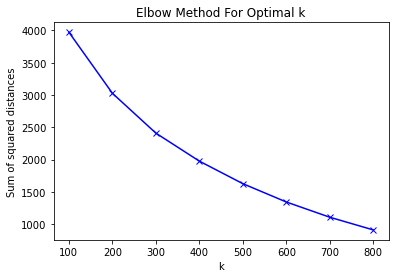

In [283]:
plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow point is around 200. We will use 200 as the number of clusters for this dataset

In [335]:
kmeans = KMeans(n_clusters=200)
kmeans.fit(vec)
output = pd.concat([df_food['Food'],pd.DataFrame(vec.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
output['cluster'] = kmeans.predict(vec)
output.head()

,Food,abalon,acacia,ad,african,albumen,alcohol,alfalfa,allsort,almond,...,yellowey,yellowfin,yellowtail,yoghurt,yoghurtco,yolk,young,zn,zucchini,cluster
0,"Cardamom seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76
1,"Cinnamon, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,124
2,"Cloves, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,124
3,"Coriander seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76
4,"Cumin (cummin) seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76


In [338]:
cluster_count = output["cluster"].value_counts().rename_axis('unique_cluster').reset_index(name='counts')
cluster_count.head(10)

,unique_cluster,counts
0,5,88
1,105,84
2,35,44
3,15,39
4,47,31
5,9,26
6,73,25
7,124,24
8,3,23
9,146,21


In [339]:
#Clusters that have only one food 
cluster_count[cluster_count['counts'] == 1]

,unique_cluster,counts
195,149,1
196,32,1
197,196,1
198,119,1
199,176,1


In [403]:
output[output['cluster'].isin([149, 32, 196, 119, 176])]['Food']

68      Coffee, flat white/latte/cappuccino, from grou...
95                        Tea, green, plain, without milk
311     Macaroni & cheese, homemade, cooked unfilled p...
1159    Fish, battered or crumbed, from takeaway outle...
1187               Squid or calamari, fried, no added fat
Name: Food, dtype: object

We have only 5 food names that are in clusters of 1

In [393]:
#Find common label for each cluster and use that as cluster's category
clusters_all = output['cluster'].unique() #all cluster numbers
categories = [] #empty list storing all labels

for i in range(len(clusters_all)):
    cluster = output[output['cluster'] == clusters_all[i]] #display each food of each cluster
    
    #find column names (from output) that have a value >0 for every row in a each cluster
    #if cell is > 0, replace it with the word of that column's header
    #if cell = 0, replace it with None
    find_common_words = np.where(cluster.all()!=0,cluster.columns,None)
    
    #create label for each cluster by joining all common words in each cluster together
    label = ' '.join([x for x in find_common_words if x and x!='Food' and x!='cluster' and len(x.split()) == 1])
    categories.append(label)

category_cluster_df = pd.DataFrame(zip(clusters_all,categories),columns=['cluster','category'])
categorized_output = pd.merge(output,category_cluster_df,on='cluster',how='left')
categorized_output.head(10)

,Food,abalon,acacia,ad,african,albumen,alcohol,alfalfa,allsort,almond,...,yellowfin,yellowtail,yoghurt,yoghurtco,yolk,young,zn,zucchini,cluster,category
0,"Cardamom seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,76,seed
1,"Cinnamon, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,dri
2,"Cloves, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,dri
3,"Coriander seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,76,seed
4,"Cumin (cummin) seed, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,76,seed
5,Curry powder,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder
6,"Fenugreek seed, dried",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,76,seed
7,"Ginger, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,dri
8,Mustard powder,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder
9,"Nutmeg, dried, ground",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,dri


In [394]:
#Example: Cluster 55 with the 'powder' category
categorized_output[categorized_output['cluster'] == 55].head()

,Food,abalon,acacia,ad,african,albumen,alcohol,alfalfa,allsort,almond,...,yellowfin,yellowtail,yoghurt,yoghurtco,yolk,young,zn,zucchini,cluster,category
5,Curry powder,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder
8,Mustard powder,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder
11,"Paprika, dry powder",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder
20,"Stock, dry powder or cube",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder
22,"Baking powder, dry powder",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,55,powder


In [395]:
#Example: Cluster 31 with 'cow fat milk' category
categorized_output[categorized_output['category'] == 'cow fat milk'].head()

,Food,abalon,acacia,ad,african,albumen,alcohol,alfalfa,allsort,almond,...,yellowfin,yellowtail,yoghurt,yoghurtco,yolk,young,zn,zucchini,cluster,category
397,"Milk, cow, fluid, regular fat (3.5% fat)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,cow fat milk
398,"Milk, cow, fluid, regular fat (3.5% fat), added omega 3 polyunsaturates",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,cow fat milk
399,"Milk, cow, fluid, reduced fat (1% fat)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,cow fat milk
400,"Milk, cow, fluid, reduced fat (1.5% fat), added omega 3 polyunsaturates",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,cow fat milk
401,"Milk, cow, fluid, skim (0.15% fat)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,cow fat milk


In [400]:
category_counts = categorized_output["category"].value_counts().rename_axis('category').reset_index(name='counts')
category_counts.head(10)

,category,counts
0,,118
1,raw,102
2,fresh,44
3,peel raw,39
4,dri,32
5,uncook,31
6,drain,26
7,pork raw,25
8,ad fri,25
9,commerci,23


In [401]:
treemap_data = category_counts[(category_counts['category'] != '') & (summary['counts'] > 1)]
fig = px.treemap(treemap_data,path=['category'],values='counts')
fig.show()

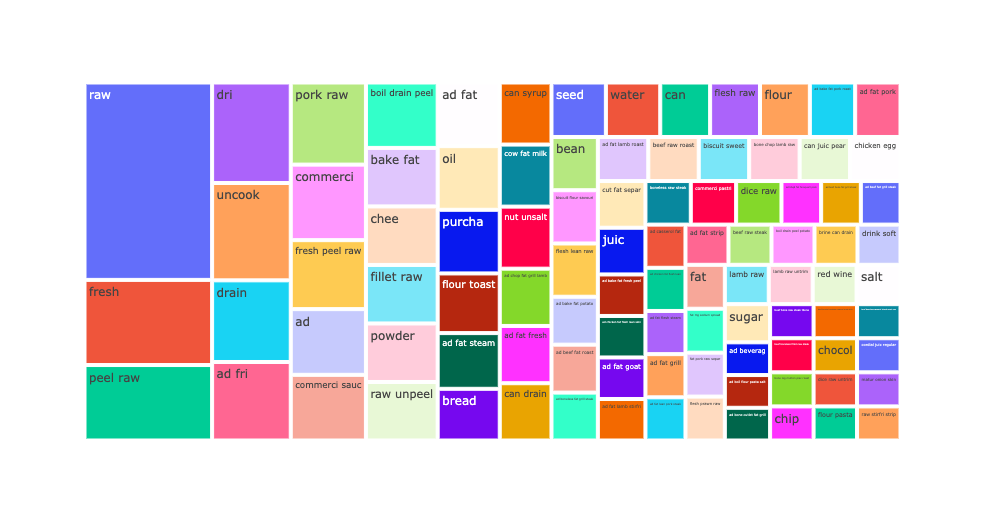

- Out of 1617 food, 118 of them are not labeled and only 5 clusters with 1 food each. 
- Some of the most popular clusters include raw, fresh, peel raw, dried

## Hierarchical Clustering (Agglomerative)

Agglomerative: place every element into a cluster of its own initially, then combining them into bigger clusters in a recursive way until they all belong in one big cluster.

In [445]:
#cosine distance matrix
cosine_distance = 1 - cosine_similarity(vec)
linkage_matrix = ward(cosine_distance)

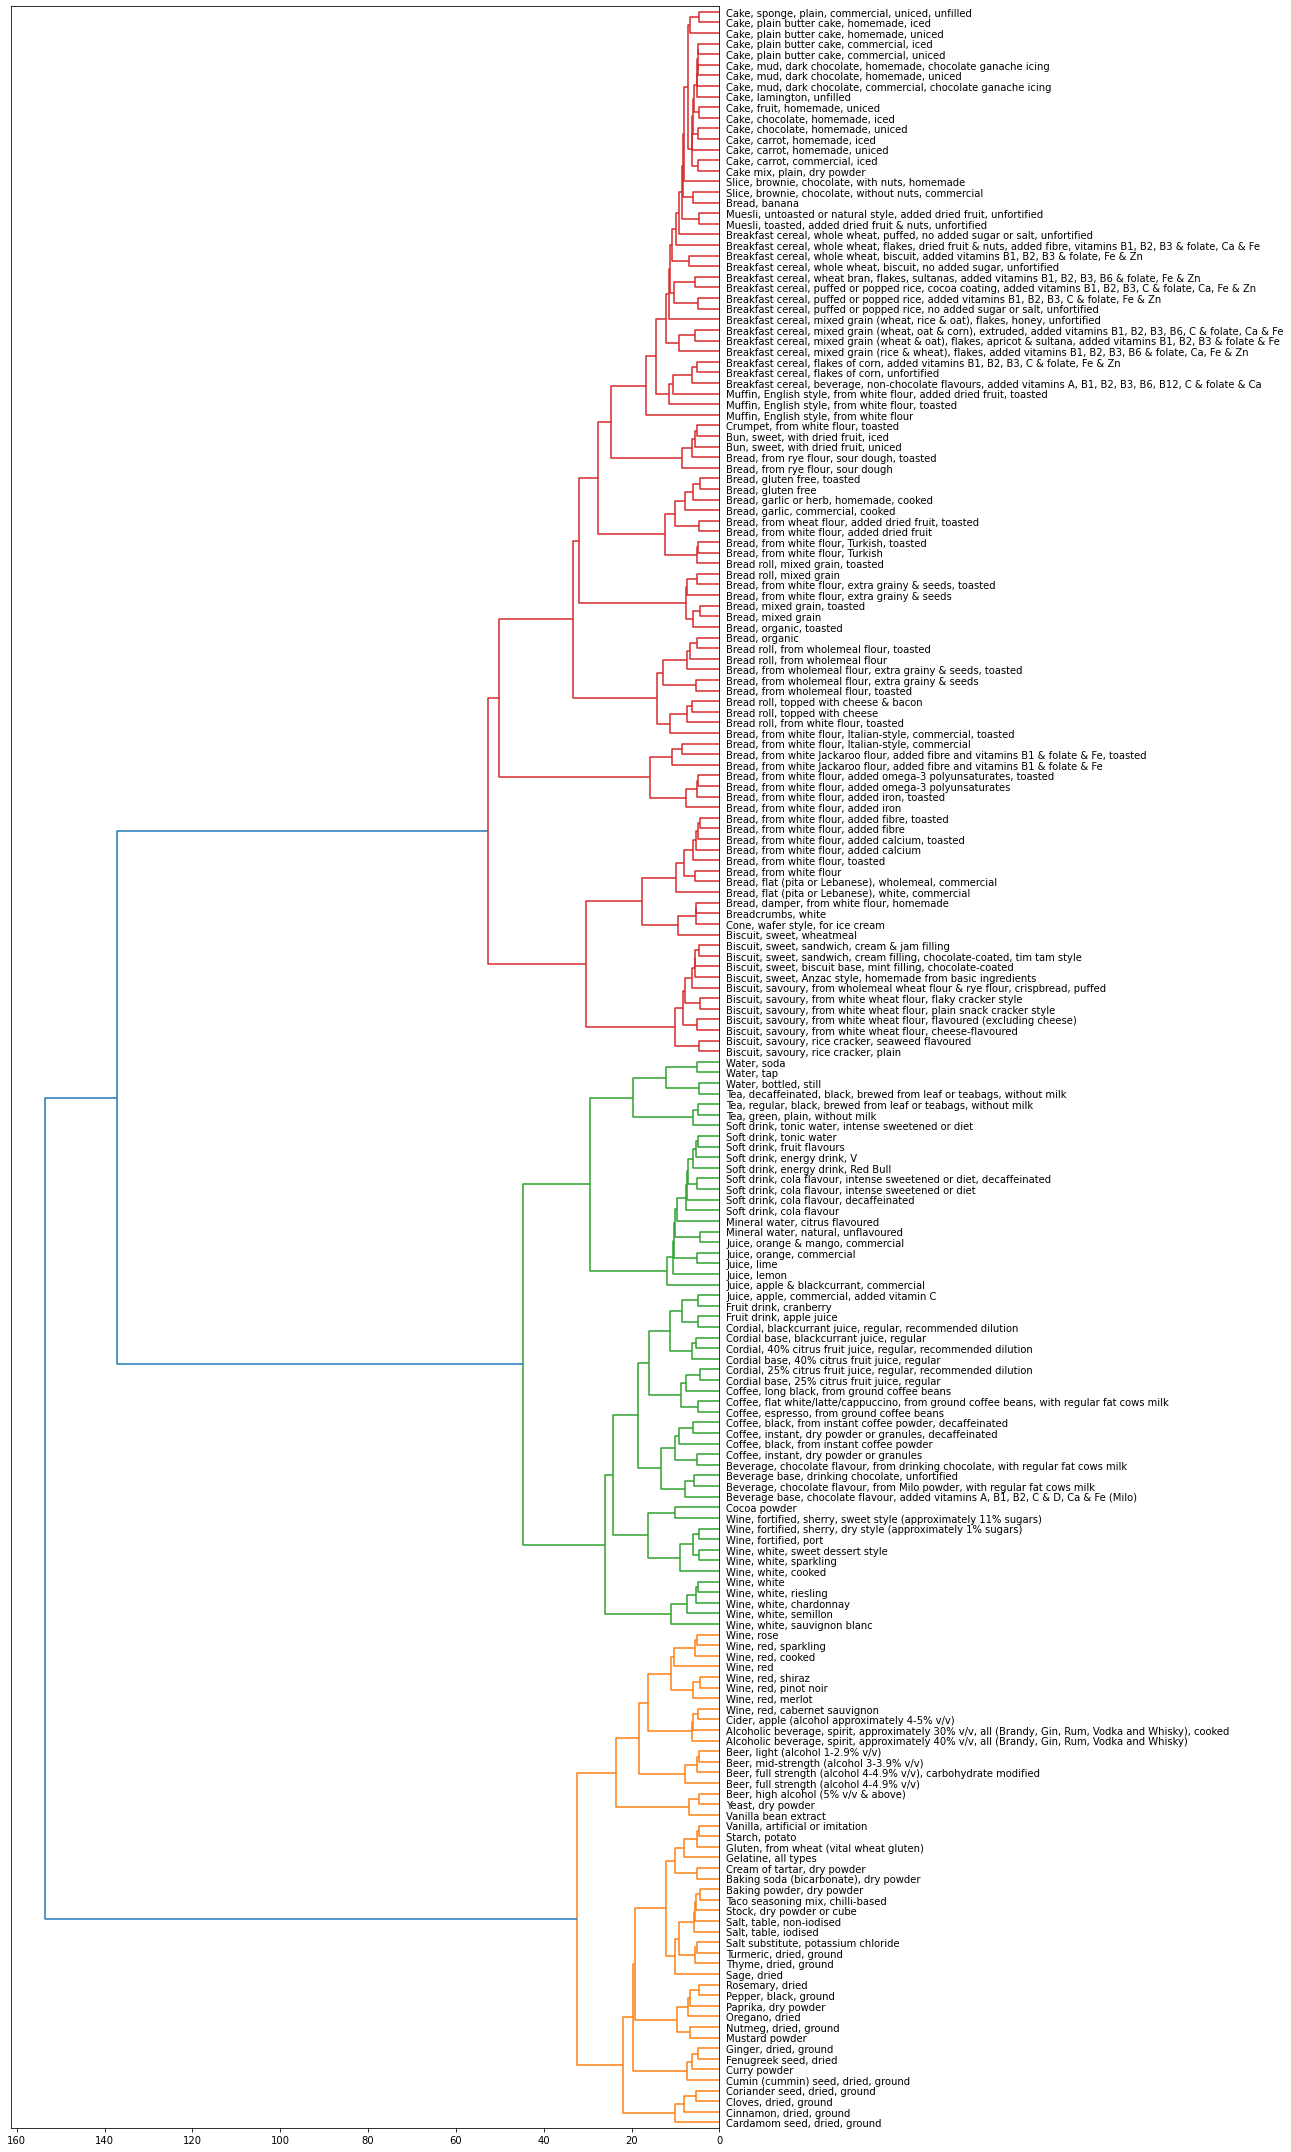

In [443]:
fig, ax = plt.subplots(figsize=(18, 30))

food = categorized_output['Food'].values.tolist()

#first dendogram to get the dictionary used to create label map
R = dendrogram(linkage_matrix, orientation="left", labels=food, truncate_mode='lastp', p=200, no_plot=True)

#create label dictionary
temp = {R["leaves"][ii]: food[ii] for ii in range(len(R["leaves"]))}
def leaf_label_func(xx):
    return "{}".format(temp[xx])

ax = dendrogram(linkage_matrix, truncate_mode='lastp', orientation="left", 
                p=200, labels = food, leaf_label_func=leaf_label_func, leaf_font_size=10.,)

plt.tight_layout()
plt.show()